## 29. Pix2Pix

In [1]:
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 29.1 Load Data

In [3]:
source_data = dsets.SVHN(root='data/',
                          split='train',
                          transform=transforms.Compose([
                                    transforms.Grayscale(),
                                    transforms.ToTensor(),
                                    ]),
                          download=True)

target_data = dsets.SVHN(root='data/',
                          split='train',
                          transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    ]),
                          download=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/train_32x32.mat


In [4]:
batch_size = 100

source_loader = torch.utils.data.DataLoader(dataset=source_data,
                                         batch_size=batch_size,
                                         shuffle=False)

target_loader  = torch.utils.data.DataLoader(dataset=target_data,
                                           batch_size=batch_size,
                                           shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 20))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

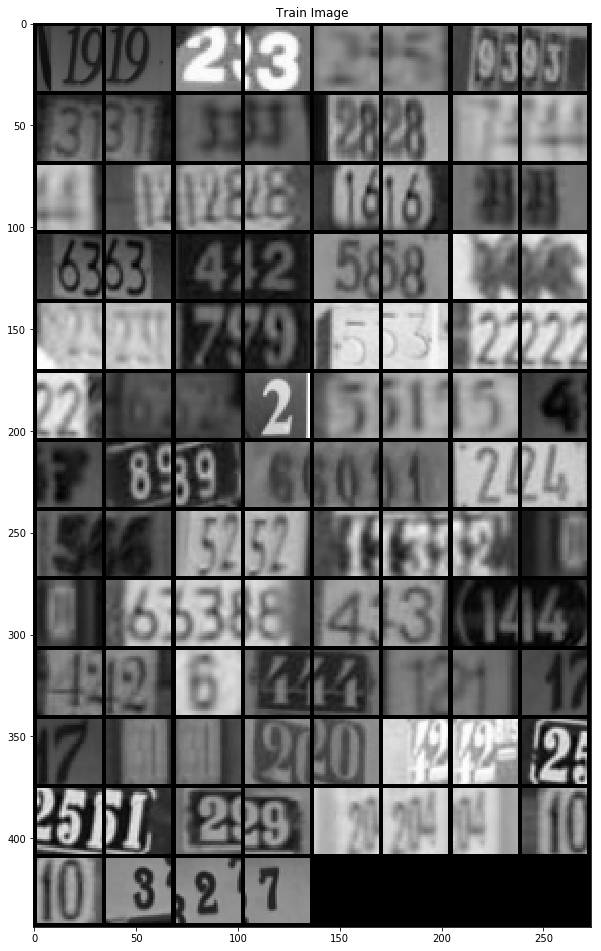

In [6]:
images, labels = iter(source_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

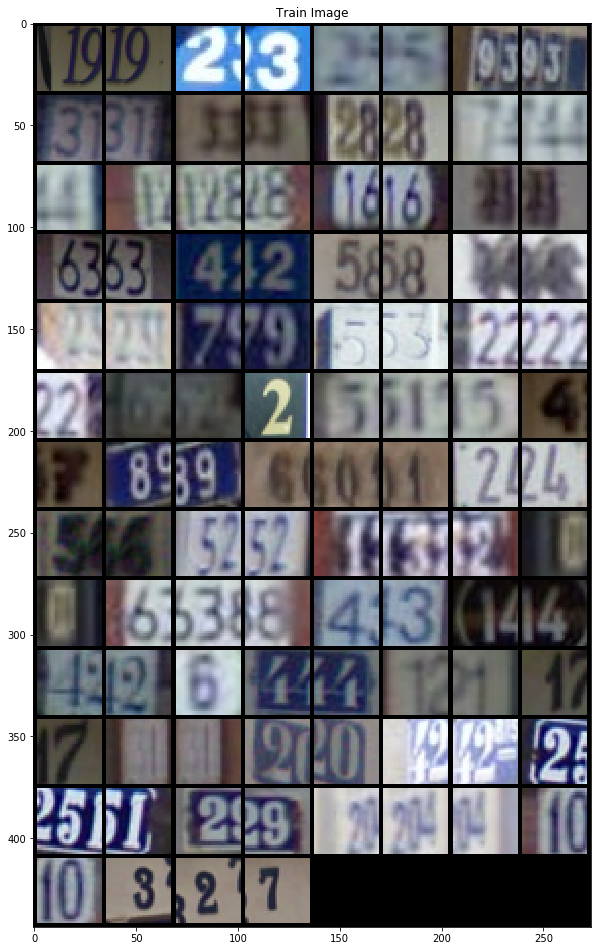

In [7]:
images, labels = iter(target_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 29.2 Define Model

In [8]:
def downconvs(in_channels, out_channels, kernel_size, leakyrelu) :
    conv = [nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=0),
        nn.BatchNorm2d(out_channels)]

    if leakyrelu :
        conv.append(nn.LeakyReLU(0.2))

    else : 
        conv.append(nn.ReLU())

    return nn.Sequential(*conv)

def upconvs(in_channels, out_channels, kernel_size, leakyrelu) :
    conv = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=0),
        nn.Dropout2d(0.5),
        nn.BatchNorm2d(out_channels)]

    if leakyrelu :
        conv.append(nn.LeakyReLU(0.2))
    else : 
        conv.append(nn.ReLU())

    return nn.Sequential(*conv)

In [9]:
class Generator(nn.Module) :
    def __init__(self):
        super(Generator, self).__init__()
        
        self.c1 = downconvs(1, 16, 2, True)       
        self.c2 = downconvs(16, 32, 2, True)        
        self.c3 = downconvs(32, 64, 2, True)        
        self.c4 = downconvs(64, 128, 2, True)
        self.c5 = nn.Sequential(
            nn.Conv2d(128, 256, 2, stride=1, padding=0),
            nn.ReLU()
        )
        
        self.uc1 = upconvs(256, 128, 2, False)
        self.uc2 = upconvs(256, 64, 2, False)
        self.uc3 = upconvs(128, 32, 2, False)
        self.uc4 = upconvs(64, 16, 2, False)
        
        self.uc5 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 2, stride=2, padding=0),
            nn.Tanh()
        )
        
    def forward(self, x) :
        
        x1 = self.c1(x)
        x2 = self.c2(x1)
        x3 = self.c3(x2)
        x4 = self.c4(x3)
        x5 = self.c5(x4)
        
        out = torch.cat([x4,self.uc1(x5)], 1)
        out = torch.cat([x3,self.uc2(out)], 1)
        out = torch.cat([x2,self.uc3(out)], 1)
        out = torch.cat([x1,self.uc4(out)], 1)
        
        out = self.uc5(out)
        
        return out

In [10]:
G = Generator().cuda()

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(4, 32, 2, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 2, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=2, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.main(x)
        out = out.view(-1, 1)
        
        return out

In [12]:
D = Discriminator().cuda()

In [13]:
z = torch.randn((1, 4, 32, 32))
D(z.cuda()).shape

torch.Size([9, 1])

In [14]:
z = torch.randn((100, 4, 32, 32))
D(z.cuda()).shape

torch.Size([900, 1])

## 29.3 Train Model

In [15]:
l1_loss = nn.L1Loss()

In [16]:
def gan_loss(x, target_is_real):
    
    loss = nn.MSELoss()
    
    if target_is_real : 
        target_tensor = torch.ones_like(x)
    else :
        target_tensor = torch.zeros_like(x)
        
    return loss(x, target_tensor.cuda())

In [17]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)

In [18]:
num_epoch = 50

In [19]:
for epoch in range(num_epoch) :
    
    total_batch = len(target_data) // batch_size
    
    source_dataiter = iter(source_loader)
    target_dataiter = iter(target_loader)

    for i in range(total_batch) : 
        
        source_img, _ = source_dataiter.next()
        target_img, _ = target_dataiter.next()

        target_img = target_img.cuda()
        source_img = source_img.cuda()

        prob_real = D(torch.cat([target_img,source_img], 1))
        D_loss_real = gan_loss(prob_real, True)

        fake_img = G(source_img)
        prob_fake = D(torch.cat([fake_img,source_img], 1))
        D_loss_fake = gan_loss(prob_fake, False)

        D_loss = (D_loss_real + D_loss_fake) * 0.5

        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        fake_img = G(source_img)
        prob_fake = D(torch.cat([fake_img,source_img], 1))
        G_loss_fake = gan_loss(prob_fake, True)
        G_loss_L1 = l1_loss(fake_img, target_img)

        G_loss = G_loss_fake + G_loss_L1 * 500

        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epoch, i+1, total_batch, D_loss.item(), G_loss.item()))

Epoch [1/50], lter [100/732], D_Loss: 0.1372, G_Loss: 202.7820
Epoch [1/50], lter [200/732], D_Loss: 0.0488, G_Loss: 171.4568
Epoch [1/50], lter [300/732], D_Loss: 0.0231, G_Loss: 130.4091
Epoch [1/50], lter [400/732], D_Loss: 0.0169, G_Loss: 123.6485
Epoch [1/50], lter [500/732], D_Loss: 0.0432, G_Loss: 90.5393
Epoch [1/50], lter [600/732], D_Loss: 0.0594, G_Loss: 76.1967
Epoch [1/50], lter [700/732], D_Loss: 0.0661, G_Loss: 67.0891
Epoch [2/50], lter [100/732], D_Loss: 0.1179, G_Loss: 58.1696
Epoch [2/50], lter [200/732], D_Loss: 0.1443, G_Loss: 55.1716
Epoch [2/50], lter [300/732], D_Loss: 0.1547, G_Loss: 43.7774
Epoch [2/50], lter [400/732], D_Loss: 0.1220, G_Loss: 45.5662
Epoch [2/50], lter [500/732], D_Loss: 0.1351, G_Loss: 41.3058
Epoch [2/50], lter [600/732], D_Loss: 0.1602, G_Loss: 38.0897
Epoch [2/50], lter [700/732], D_Loss: 0.1375, G_Loss: 37.0426
Epoch [3/50], lter [100/732], D_Loss: 0.1231, G_Loss: 34.6344
Epoch [3/50], lter [200/732], D_Loss: 0.1262, G_Loss: 33.2627
Epoc

Epoch [38/50], lter [200/732], D_Loss: 0.1482, G_Loss: 14.0017
Epoch [38/50], lter [300/732], D_Loss: 0.1864, G_Loss: 13.4192
Epoch [38/50], lter [400/732], D_Loss: 0.1110, G_Loss: 18.0461
Epoch [38/50], lter [500/732], D_Loss: 0.0969, G_Loss: 15.6259
Epoch [38/50], lter [600/732], D_Loss: 0.0859, G_Loss: 15.6090
Epoch [38/50], lter [700/732], D_Loss: 0.1465, G_Loss: 15.7569
Epoch [39/50], lter [100/732], D_Loss: 0.1564, G_Loss: 14.4881
Epoch [39/50], lter [200/732], D_Loss: 0.1468, G_Loss: 13.6935
Epoch [39/50], lter [300/732], D_Loss: 0.1511, G_Loss: 12.0615
Epoch [39/50], lter [400/732], D_Loss: 0.0905, G_Loss: 17.8884
Epoch [39/50], lter [500/732], D_Loss: 0.1356, G_Loss: 15.4747
Epoch [39/50], lter [600/732], D_Loss: 0.0562, G_Loss: 16.0856
Epoch [39/50], lter [700/732], D_Loss: 0.1568, G_Loss: 15.3429
Epoch [40/50], lter [100/732], D_Loss: 0.1161, G_Loss: 15.1923
Epoch [40/50], lter [200/732], D_Loss: 0.0802, G_Loss: 14.3343
Epoch [40/50], lter [300/732], D_Loss: 0.1677, G_Loss: 

## 29.4 Test Model

In [20]:
source_test_data = dsets.SVHN(root='data/',
                              split='test',
                              transform=transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.ToTensor(),
                                        ]),
                              download=True)

target_test_data = dsets.SVHN(root='data/',
                              split='test',
                              transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        ]),
                              download=True)

Using downloaded and verified file: data/test_32x32.mat


In [37]:
batch_size = 5

source_test_loader = torch.utils.data.DataLoader(dataset=source_test_data,
                                                 batch_size=batch_size,
                                                 shuffle=False)

target_test_loader  = torch.utils.data.DataLoader(dataset=target_test_data,
                                                  batch_size=batch_size,
                                                  shuffle=False)

----------------------------------------------------------------------------------------------------
-  0 th Results


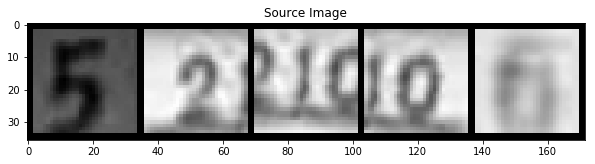

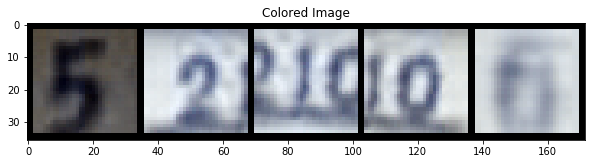

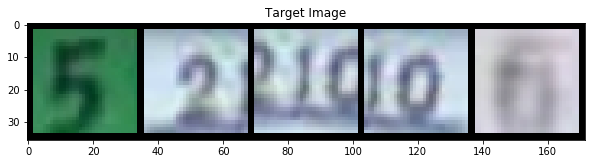

----------------------------------------------------------------------------------------------------
-  1 th Results


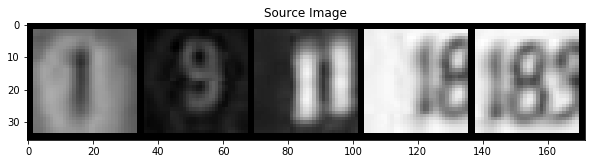

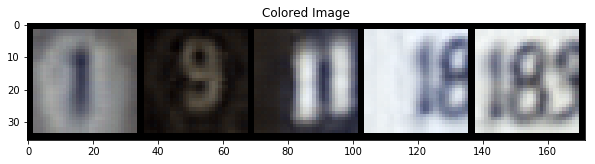

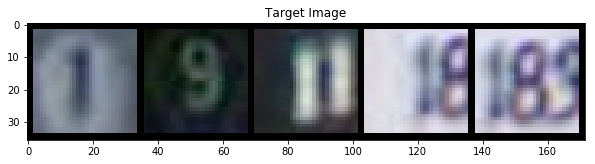

----------------------------------------------------------------------------------------------------
-  2 th Results


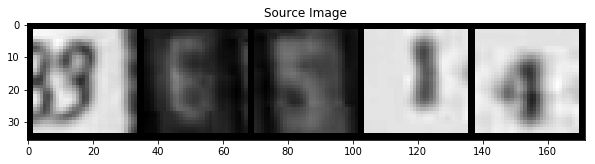

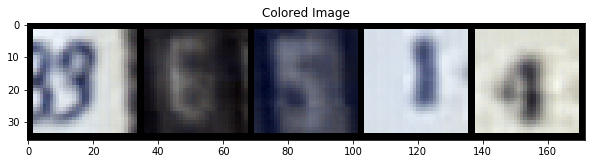

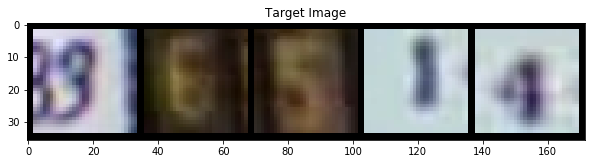

----------------------------------------------------------------------------------------------------
-  3 th Results


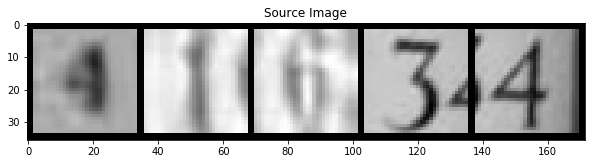

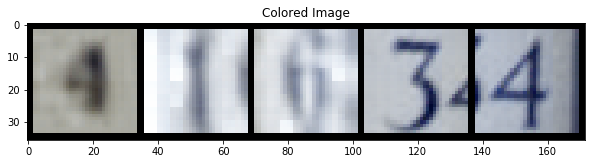

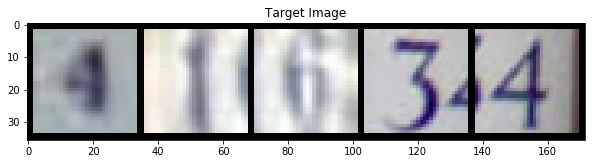

----------------------------------------------------------------------------------------------------
-  4 th Results


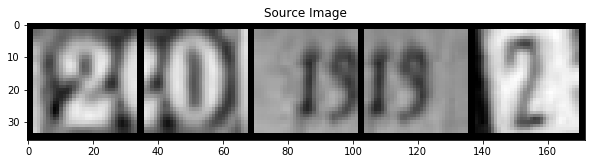

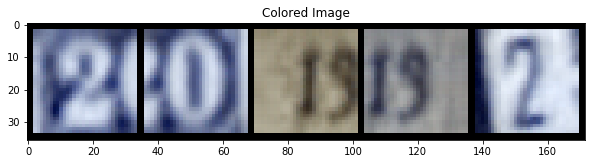

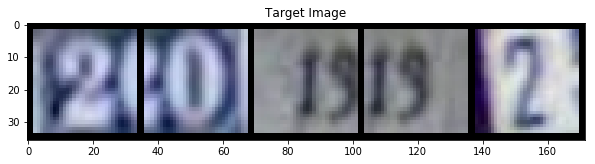

----------------------------------------------------------------------------------------------------
-  5 th Results


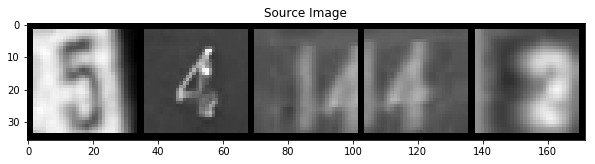

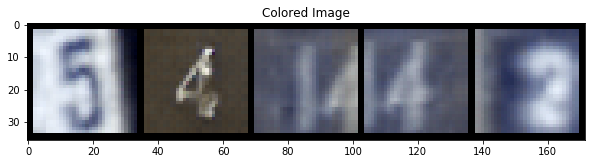

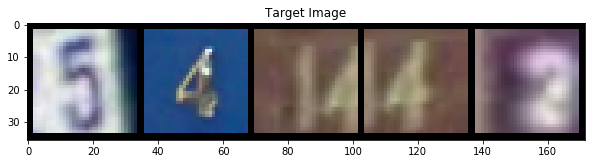

----------------------------------------------------------------------------------------------------
-  6 th Results


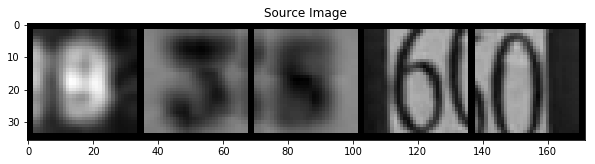

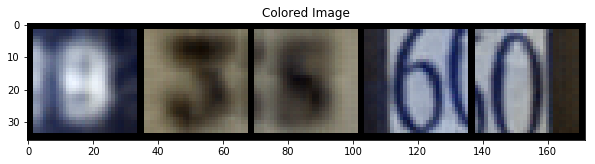

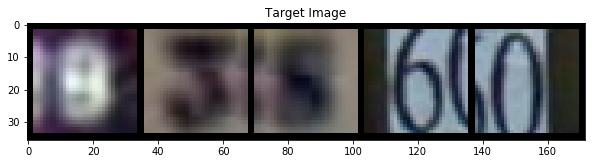

----------------------------------------------------------------------------------------------------
-  7 th Results


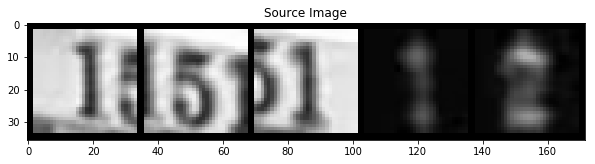

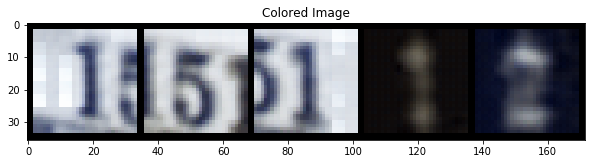

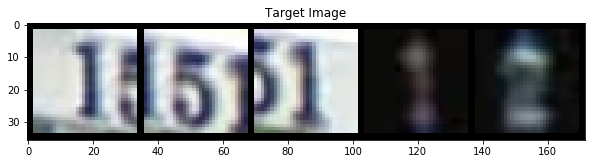

----------------------------------------------------------------------------------------------------
-  8 th Results


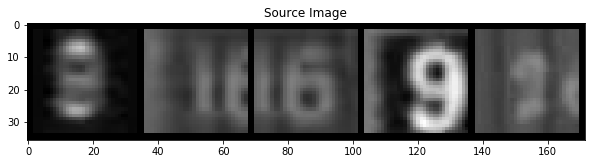

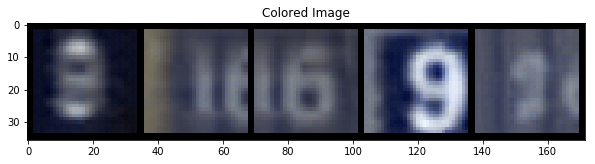

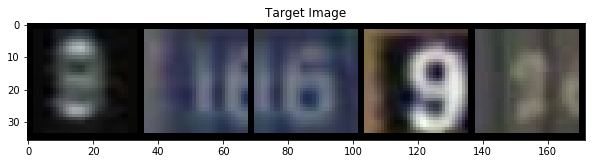

----------------------------------------------------------------------------------------------------
-  9 th Results


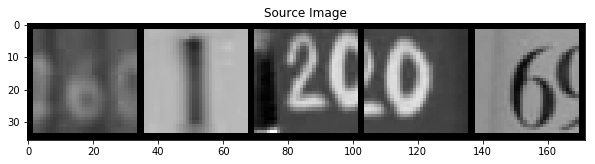

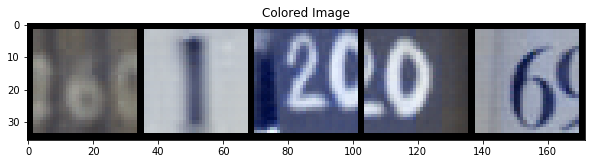

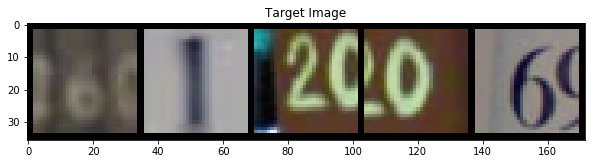

In [45]:
G.eval()

source_test_iter = iter(source_test_loader)
target_test_iter = iter(target_test_loader)

for i in range(10) :

    print('-'*100)
    print('- ', i, 'th Results')
    
    source_images, _ = source_test_iter.next()
    target_images, _ = target_test_iter.next()

    colored_images = G(source_images.cuda()).data.cpu()
    
    imshow(torchvision.utils.make_grid(source_images, normalize=True), "Source Image")
    imshow(torchvision.utils.make_grid(colored_images, normalize=True), "Colored Image")
    imshow(torchvision.utils.make_grid(target_images, normalize=True), "Target Image")